In [12]:
import pandas as pd
import PyPDF2
import numpy as np
import math
from extractors.abstract_extractor import AbstractExractor
from utils.data.visualisation import visualiseIndividualfromDF, visualiseIndividualinMPL
from utils.extract_utils.extract_utils import rotate_origin_only, move_along_the_axis, scale_values_based_on_eich_peak, \
    create_measurement_points, adjust_leads_baseline, preprocess_page_content, extract_graphics_string
from utils.misc.datastructure import perform_shape_switch
import logging
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [10]:
# reference value for the calibration jag
eich_ref = 1000

# extracted height for the calibration jag in PDF
eichzacke = 28.34800000000001

# factor for scaling
gamma = eich_ref / eichzacke

# name of the leads
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

#source data
path_source = os.getcwd()
filename = os.path.join(path_source, 'data_test\\EKG_131515-20_0.pdf')

#Extract leads
#lead_list = extract_leads_from_pdf(file_name)

reader = PyPDF2.PdfFileReader(open(filename, 'rb'))

num_pages = reader.getNumPages()
pg1 = reader.getPage(0).getContents()._data

#convert pdf hex symptoms to string of Latin-1 endoded bytes (each character= 1 byte) 
pg1 = preprocess_page_content(pg1)

#split series of PDF converted to strings to list of objects
pg1_objects = (pg1).split('S')

#412 - I short

#423 - V5 short
#427 - V1 long

lead_idx = 412

#v5 trace object
v5_lead_object = pg1_objects[lead_idx]
#remove m(mark?) and l (line?) markers in PDF
v5_lead_raw = v5_lead_object.replace(' l', '').replace(' m', '')
#split each sample by newline
v5_lead_raw = v5_lead_raw.split('\n')

#split x and y coordinate into separate columns
v5_xy_col = []

for r in v5_lead_raw[2:-1]:
    #get coordinates as string
    tmp_xy = r.split(' ')
    #cast string x,y coordinates as int
    tmp_xy = [int(i) for i in tmp_xy]
    #append to trace array
    v5_xy_col.append(tmp_xy)

v5_xy_arr = np.array(v5_xy_col)

#save np array as CSV
np.savetxt("v5_exp.csv", v5_xy_arr, delimiter=",")




Plot traces for each lead

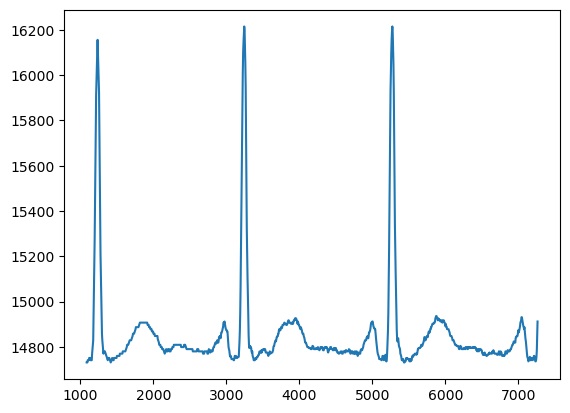

In [22]:
#Plot x,y traces of each lead in discovery run
fig, ax = plt.subplots()

ax.plot(v5_xy_arr[:,0], v5_xy_arr[:,1], markeredgewidth=2)
plt.show()

#ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#       ylim=(0, 8), yticks=np.arange(1, 8))

x =v5_xy_arr[0,:]

In [3]:
#calibration_marker
cal_mark =pg1_objects[425]
#remove m(mark?) and l (line?) markers in PDF
cal_mark = cal_mark.replace(' l', '').replace(' m', '')
#split each sample by newline
cal_mark = cal_mark.split('\n')

cal_xy = []
for r in cal_mark[1:-1]:
    #get coordinates as string
    tmp_cal_xy = r.split(' ')
    #cast string x,y coordinates as int
    tmp_cal_xy = [int(i) for i in tmp_cal_xy]
    #append to trace array
    cal_xy.append(tmp_cal_xy)

cal_xy_arr = np.array(cal_xy)

#save np array as CSV
np.savetxt("cal_xy.csv", cal_xy_arr, delimiter=",")


In [65]:
    def collectLeads(graphicsstring, lower=7, upper=18):
        leads = []
        leads_raw = graphicsstring[0].split('C')

        for z in leads_raw[lower:upper: 2]:
            tmp = str(z).split('\n')

            lead = []
            for p in tmp:
                coordinates = p.split(' ')
                if len(coordinates) == 2:
                    lead.append(coordinates)

            lead = np.array(lead)
            leads.append(lead)

        return leads, leads_raw 

In [66]:

    
        reader = PyPDF2.PdfFileReader(open(self.path_source + filename, 'rb'))

        num_pages = reader.getNumPages()
        if num_pages == 3:
            pg1 = reader.getPage(1).getContents()._data
            pg2 = reader.getPage(2).getContents()._data
        else:
            pg1 = reader.getPage(0).getContents()._data
            pg2 = reader.getPage(1).getContents()._data
        pg1 = preprocess_page_content(pg1)
        pg1 = extract_graphics_string(pg1)
        pg2 = preprocess_page_content(pg2)
        pg2 = extract_graphics_string(pg2)

        leads1 = self.collectLeads(pg1, 7, 18)
        leads2 = self.collectLeads(pg2, 7, 18)
        leads = leads1 + leads2

        correct_extracted = [False if (len(x) < 700 or len(x) > 800) else True for x in leads]
        if False in correct_extracted:
            leads1 = self.collectLeads(pg1, 8, 19)
            leads2 = self.collectLeads(pg2, 8, 19)
            leads = leads1 + leads2

        correct_extracted = [False if (len(x) < 700 or len(x) > 800) else True for x in leads]
        if False in correct_extracted:
            leads1 = self.collectLeads(pg1, 9, 20)
            leads2 = self.collectLeads(pg2, 9, 20)
            leads = leads1 + leads2

        correct_extracted = [False if (len(x) < 700 or len(x) > 800) else True for x in leads]
        if False in correct_extracted:
            raise Exception('Special case: External limits for the extraction may not be correct!')

        return leads

NameError: name 'self' is not defined